# Reflectance and Transmittance Spectra for Planewave at Oblique Incidence

As an additional demonstration of the mode-decomposition feature, the reflectance and transmittance of all diffracted orders for any grating with no material absorption and a planewave source incident at any arbitrary angle and wavelength must necessarily sum to unity. Also, the total reflectance and transmittance must be equivalent to values computed using the Poynting flux. This demonstration is somewhat similar to the [single-mode waveguide example](https://nbviewer.jupyter.org/github/NanoComp/meep/blob/master/python/examples/mode-decomposition.ipynb).

The following example is adapted from the previous binary-grating example involving a [normally-incident planewave](https://nbviewer.jupyter.org/github/NanoComp/meep/blob/master/python/examples/binary_grating.ipynb). 

The total reflectance, transmittance, and their sum are plotted at the end of the simulation.

Results are computed for a single wavelength of 0.5 μm. The pulsed planewave is incident at an angle of 10.7°. Its spatial profile is defined using the source amplitude function `pw_amp`. This [anonymous function](https://en.wikipedia.org/wiki/Anonymous_function) takes two arguments, the wavevector and a point in space (both `mp.Vector3`s), and returns a function of one argument which defines the planewave amplitude at that point. A narrow bandwidth pulse is used in order to mitigate the intrinsic discretization effects of the [Yee grid](../Yee_Lattice.md) for oblique planewaves. Also, the `stop_when_fields_decayed` termination criteria is replaced with `until_after_sources`. As a general rule of thumb, the more oblique the planewave source, the longer the run time required to ensure accurate results. There is an additional line monitor between the source and the grating for computing the reflectance. The angle of each reflected/transmitted mode, which can be positive or negative, is computed using its dominant planewave vector. Since the oblique source breaks the symmetry in the $y$ direction, each diffracted order must be computed separately. In total, there are 59 reflected and 39 transmitted orders.

As usual, we'll begin by loading our required modules:

In [1]:
import meep as mp
import math
import cmath
import numpy as np
from matplotlib import pyplot as plt

Using MPI version 3.1, 1 processes


Next we'll define our simulation domain:

In [2]:
resolution = 50        # pixels/μm

dpml = 1.0             # PML thickness
dsub = 3.0             # substrate thickness
dpad = 3.0             # length of padding between grating and PML
gp = 10.0              # grating period
gh = 0.5               # grating height
gdc = 0.5              # grating duty cycle

sx = dpml+dsub+gh+dpad+dpml
sy = gp

cell_size = mp.Vector3(sx,sy,0)
pml_layers = [mp.PML(thickness=dpml,direction=mp.X)] 

We can now define the oblique source we'll use to excite the grating structure.

In [3]:
ng = 1.5
glass = mp.Medium(index=ng)

wvl = 0.5              # center wavelength
fcen = 1/wvl           # center frequency
df = 0.05*fcen         # frequency width

# rotation angle of incident planewave; counter clockwise (CCW) about Z axis, 0 degrees along +X axis
theta_in = math.radians(10.7)

# k (in source medium) with correct length (plane of incidence: XY)
k = mp.Vector3(fcen*ng).rotate(mp.Vector3(z=1), theta_in)

symmetries = []
eig_parity = mp.ODD_Z
if theta_in == 0:
  k = mp.Vector3(0,0,0)
  symmetries = [mp.Mirror(mp.Y)]
  eig_parity += mp.EVEN_Y

def pw_amp(k,x0):
  def _pw_amp(x):
    return cmath.exp(1j*2*math.pi*k.dot(x+x0))
  return _pw_amp

src_pt = mp.Vector3(-0.5*sx+dpml+0.3*dsub,0,0)
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ez,
                     center=src_pt,
                     size=mp.Vector3(0,sy,0),
                     amp_func=pw_amp(k,src_pt))]

We'll now initialize our simulation object. Since our first run is a normalization run, we'll set the entire domain to be the same material (glass in this case).

In [4]:
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    k_point=k,
                    default_material=glass,
                    sources=sources,
                    symmetries=symmetries)

refl_pt = mp.Vector3(-0.5*sx+dpml+0.5*dsub,0,0)
refl_flux = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=refl_pt, size=mp.Vector3(0,sy,0)))

Since everything looks as expected, we can now run our normalization simulation. We'll record the flux data for future use.

In [5]:
sim.run(until_after_sources=100)

input_flux = mp.get_fluxes(refl_flux)
input_flux_data = sim.get_flux_data(refl_flux)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 2D dimensions.
Computational cell is 8.5 x 10 x 0 with resolution 50
time for set_epsilon = 0.246638 s
-----------
Meep: using complex fields.
Meep progress: 15.3/200.0 = 7.7% done in 4.0s, 48.3s to go
on time step 1530 (time=15.3), 0.00261487 s/step
Meep progress: 28.44/200.0 = 14.2% done in 8.0s, 48.3s to go
on time step 2844 (time=28.44), 0.00304522 s/step
Meep progress: 42.58/200.0 = 21.3% done in 12.0s, 44.4s to go
on time step 4258 (time=42.58), 0.0028297 s/step
Meep progress: 58.33/200.0 = 29.2% done in 16.0s, 38.9s to go
on time step 5833 (time=58.33), 0.00254018 s/step
Meep progress: 74.09/200.0 = 37.0% done in 20.0s, 34.0s to go
on time step 7409 (time=74.09), 0.0025383 s/step
Meep progress: 89.77/200.0 = 44.9% done in 24.0s, 29.5s to go
on time step 8977 (time=89.77), 0.00255152 s/step
Meep progress: 102.93/200.0 = 51.5% done in 28.0s, 26.4s to go
on time step 10294 (time=102.94), 

We'll now reset our simulation domain using the `reset_meep` command and generate the periodic grating structure.

In [6]:
sim.reset_meep()

geometry = [mp.Block(material=glass, size=mp.Vector3(dpml+dsub,mp.inf,mp.inf), center=mp.Vector3(-0.5*sx+0.5*(dpml+dsub),0,0)),
            mp.Block(material=glass, size=mp.Vector3(gh,gdc*gp,mp.inf), center=mp.Vector3(-0.5*sx+dpml+dsub+0.5*gh,0,0))]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    k_point=k,
                    sources=sources,
                    symmetries=symmetries)

refl_flux = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=refl_pt, size=mp.Vector3(0,sy,0)))
sim.load_minus_flux_data(refl_flux,input_flux_data)

tran_pt = mp.Vector3(0.5*sx-dpml-0.5*dpad,0,0)
tran_flux = sim.add_flux(fcen, 0, 1, mp.FluxRegion(center=tran_pt, size=mp.Vector3(0,sy,0)))

-----------
Initializing structure...
time for choose_chunkdivision = 9.17912e-05 s
Working in 2D dimensions.
Computational cell is 8.5 x 10 x 0 with resolution 50
     block, center = (-2.25,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (0,0,0)
          size (0.5,5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.488653 s
-----------
Meep: using complex fields.


Finally, we'll simulate the actual grating structure.

In [7]:
sim.run(until_after_sources=200)

Meep progress: 12.77/300.0 = 4.3% done in 4.0s, 90.0s to go
on time step 1277 (time=12.77), 0.00313307 s/step
Meep progress: 28.09/300.0 = 9.4% done in 8.0s, 77.5s to go
on time step 2809 (time=28.09), 0.00261135 s/step
Meep progress: 43.410000000000004/300.0 = 14.5% done in 12.0s, 70.9s to go
on time step 4341 (time=43.41), 0.00261123 s/step
Meep progress: 58.64/300.0 = 19.5% done in 16.0s, 65.9s to go
on time step 5865 (time=58.65), 0.00262622 s/step
Meep progress: 74.04/300.0 = 24.7% done in 20.0s, 61.1s to go
on time step 7405 (time=74.05), 0.00259861 s/step
Meep progress: 89.44/300.0 = 29.8% done in 24.0s, 56.5s to go
on time step 8945 (time=89.45), 0.00259819 s/step
Meep progress: 104.56/300.0 = 34.9% done in 28.0s, 52.4s to go
on time step 10458 (time=104.58), 0.00264506 s/step
Meep progress: 119.84/300.0 = 39.9% done in 32.0s, 48.1s to go
on time step 11986 (time=119.86), 0.00261802 s/step
Meep progress: 135.07/300.0 = 45.0% done in 36.0s, 44.0s to go
on time step 13509 (time=1

With both simulation runs complete, we can use the `get_eigenmode_coefficients` routine to extract the reflection and transmission diffraction orders and relative power.

In [8]:
# Calculate the number of reflected orders
nm_r = np.floor((fcen*ng-k.y)*gp)-np.ceil((-fcen*ng-k.y)*gp) # number of reflected orders
if theta_in == 0:
  nm_r = nm_r/2 # since eig_parity removes degeneracy in y-direction
nm_r = int(nm_r)

# Extract the coefficients for the reflected orders
res = sim.get_eigenmode_coefficients(refl_flux, range(1,nm_r+1), eig_parity=eig_parity)
r_coeffs = res.alpha

# Calculate the number of transmitted orders
nm_t = np.floor((fcen-k.y)*gp)-np.ceil((-fcen-k.y)*gp)       # number of transmitted orders
if theta_in == 0:
  nm_t = nm_t/2 # since eig_parity removes degeneracy in y-direction
nm_t = int(nm_t)

# Extract the coefficients for the transmitted orders
res = sim.get_eigenmode_coefficients(tran_flux, range(1,nm_t+1), eig_parity=eig_parity)
t_coeffs = res.alpha

MPB solved for omega_1(3,0.557,0) = 2.00021 after 235 iters
MPB solved for omega_1(2.99969,0.557,0) = 2 after 1 iters
Dominant planewave for band 1: (2.999692,-0.043000,0.000000)
MPB solved for omega_2(3,0.557,0) = 2.00036 after 156 iters
MPB solved for omega_2(2.99946,0.557,0) = 2 after 1 iters
Dominant planewave for band 2: (2.999458,0.057000,0.000000)
MPB solved for omega_3(3,0.557,0) = 2.00227 after 204 iters
MPB solved for omega_3(2.99659,0.557,0) = 2 after 1 iters
MPB solved for omega_3(2.99659,0.557,0) = 2 after 1 iters
Dominant planewave for band 3: (2.996590,-0.143000,0.000000)
MPB solved for omega_4(3,0.557,0) = 2.00274 after 104 iters
MPB solved for omega_4(2.99589,0.557,0) = 2 after 1 iters
MPB solved for omega_4(2.99589,0.557,0) = 2 after 1 iters
Dominant planewave for band 4: (2.995889,0.157000,0.000000)
MPB solved for omega_5(3,0.557,0) = 2.00655 after 137 iters
MPB solved for omega_5(2.99014,0.557,0) = 2 after 1 iters
MPB solved for omega_5(2.99014,0.557,0) = 2 after 1 

Finally, we'll compute the corresponding angles and relative powers and visualize the results.

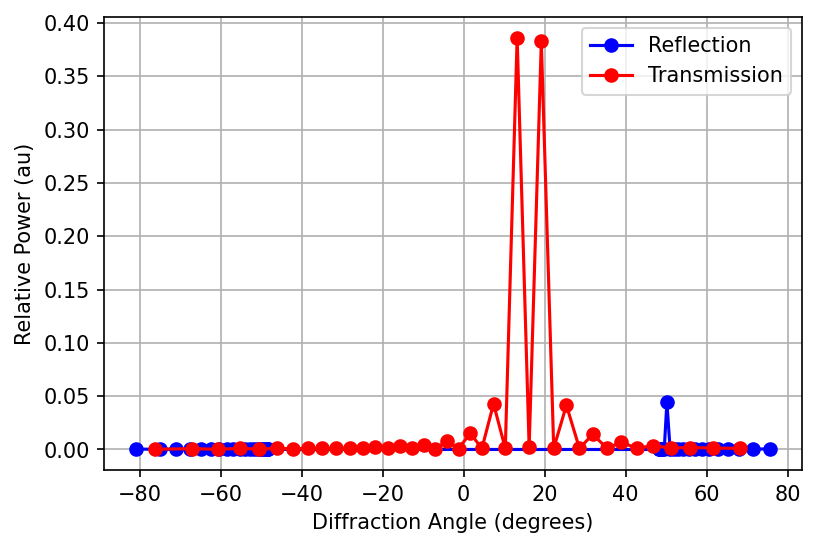

In [9]:
r_angle = np.squeeze([math.degrees(np.sign(r_kdom.y)*math.acos(r_kdom.x/(ng*fcen))) for r_kdom in res.kdom])
Rmode = abs(r_coeffs[:,0,1])**2/input_flux[0]
idx_r = np.argsort(r_angle)

t_angle = np.squeeze([math.degrees(np.sign(t_kdom.y)*math.acos(t_kdom.x/fcen)) for t_kdom in res.kdom])
Tmode = abs(t_coeffs[:,0,0])**2/input_flux[0]
idx_t = np.argsort(t_angle)

plt.figure(dpi=150)
plt.plot(r_angle[idx_r],Rmode[idx_r], 'o-',color='blue',label='Reflection')
plt.plot(t_angle[idx_t],Tmode[idx_t], 'o-',color='red',label='Transmission')
plt.grid(True)
plt.xlabel('Diffraction Angle (degrees)')
plt.ylabel('Relative Power (au)')
plt.legend()
plt.show()

As a sanity check, we'll compare the total flux derived from the `get_eigenmode_coefficients` routine to the flux computed from the flux monitors:

In [10]:
print("mode-coeff:, {:.6f}, {:.6f}, {:.6f}".format(np.sum(Rmode),np.sum(Tmode),np.sum(Rmode)+np.sum(Tmode)))
r_flux = mp.get_fluxes(refl_flux)
t_flux = mp.get_fluxes(tran_flux)
Rflux = -r_flux[0]/input_flux[0]
Tflux =  t_flux[0]/input_flux[0]
print("poynting-flux:, {:.6f}, {:.6f}, {:.6f}".format(Rflux,Tflux,Rflux+Tflux))

mode-coeff:, 0.061047, 0.937870, 0.998917
poynting-flux:, 0.061102, 0.938344, 0.999447
